## Construct Gaussian process classification to identify oxygen stoichiometry based on the intergrated data of experimental EIS data and SMOTE data

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)  #set default figure size
import os, sys
from PEMFC_project import _samplings , _equivalent_circuits, _reconstruct_Nyquist_plot,_data_summery 

In [9]:
freq = np.loadtxt('Data/PEMFC_freq.txt')
eis_train = pd.read_csv('Data/x_smote_enn_train_1.csv',header=0,index_col=None)
y_train= pd.read_csv('Data/y_smote_enn_train_1.csv',header=None,index_col=None)
eis_test = pd.read_csv('Data/x_smote_enn_test_1.csv',header=0,index_col=None)
y_test = pd.read_csv('Data/y_smote_enn_test_1.csv',header=None,index_col=None)
stoi = [[1.4, 1.5, 1.6, 1.8, 2.0, 2.2, 2.5, 3.0], [0, 1, 0, 2, 3, 4, 5, 6]]

In [10]:
eis_test.dropna(inplace=True)
print(eis_train.shape)
print(eis_test.shape)
print(y_train.shape)
print(y_test.shape)

(397, 62)
(94, 62)
(397, 1)
(94, 1)


In [11]:
a = _data_summery.target_summery(y_train)
a['counts'].sum()

397

### Training data include experimental EIS data and SMOTE data

In [12]:
y_c_train = y_train.replace(stoi[0],np.array(stoi[1]).astype(int))
y_train.rename(columns={0: 'O2 stoi.'},inplace=True)
y_c_train.rename(columns={0: 'labels'},inplace=True)
_data_summery.target_summery(y_c_train)

,counts,proportion
labels,,
4.0,94,0.236776
6.0,56,0.141058
2.0,53,0.133501
1.0,50,0.125945
5.0,50,0.125945
0.0,48,0.120907
3.0,46,0.115869


## Test data includes experimental EIS data

In [13]:
y_c_test = y_test.replace(stoi[0],np.array(stoi[1]).astype(int))
y_test.rename(columns={0: 'O2 stoi.'},inplace=True)
y_c_test.rename(columns={0: 'labels'},inplace=True)
_data_summery.target_summery(y_c_test)

,counts,proportion
labels,,
4.0,41,0.436170
2.0,24,0.255319
0.0,7,0.074468
3.0,6,0.063830
5.0,6,0.063830
6.0,6,0.063830
1.0,4,0.042553


## Standard EIS data in training and test data

In [14]:
from numpy.random import default_rng
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()
scaler.fit(eis_train)
X_train = scaler.transform(eis_train)
X_test = scaler.transform(eis_test)


In [15]:
# load gpc model
import pickle
with open('Models/gpc_smote_3.pkl','rb') as f:
    gpc_se3 = pickle.load(f)

C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator _BinaryGaussianProcessClassifierLaplace from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mero_\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 0.23.2 when using version 1.2.2. This might lead to breaking code or inv

In [16]:
test = gpc_se3.predict(X_test)

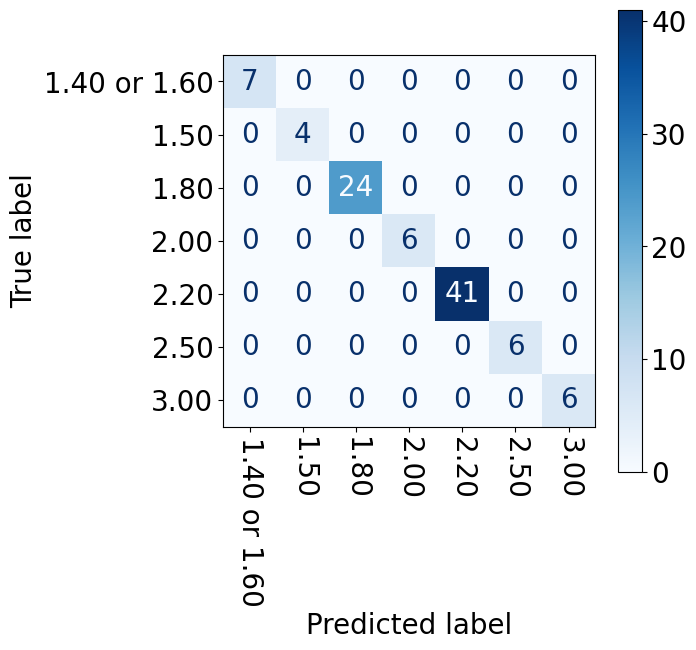

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
cm = confusion_matrix(test, y_c_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ '1.40 or 1.60', '1.50', '1.80', '2.00', '2.20', '2.50', '3.00'] )# displace_la
disp.plot(cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': 20})
plt.xticks(rotation=270)
plt.show()

### Plot EIS data in test data

(-0.006, 0.02)

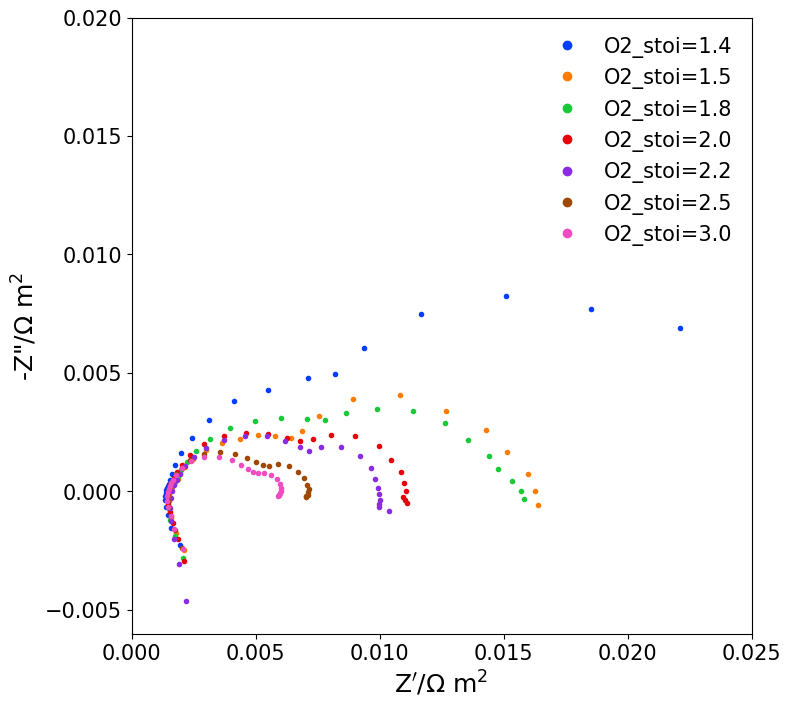

In [20]:
import seaborn as sns
plt.figure(figsize=(8,8))
target = pd.Series(test).replace([0, 1, 2, 3, 4, 5, 6],[1.4, 1.5, 1.8, 2.0, 2.2, 2.5, 3.0])
labels = []
palette = sns.color_palette("bright",len(np.unique(target))+1)
i=0
stois = [1.4,1.5,1.8,2.0,2.2,2.5,3.0]
for stoi in (stois):
    labels.append('O2_stoi=%0.1f'%stoi)
    ind = np.where(target==stoi)[0]
    eis = eis_test.iloc[ind,:]
    plt.plot(np.average(eis.iloc[:,:31],axis=0), np.average(eis.iloc[:,31:],axis=0),'.',c=palette[i],label = 'O2_stoi=%0.1f'%stoi)
    #plt.scatter(eis.iloc[::,:31],eis.iloc[::,31:],s=2,alpha=0.8,c=np.array(palette[i]).reshape(1,-1))
    i+=1
order = [0,1,2,3,4,5,6] 
handles, labels1 = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],[labels1[idx] for idx in order],loc='upper right',markerscale=2,frameon=False, fontsize=15)#
plt.xticks(np.linspace(0,2.5e-2,6),fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('-Z"/Ω $\mathregular{m^2}$', fontsize=18)
plt.xlabel('Z${\'}$/Ω $\mathregular{m^2}$', fontsize=18)
plt.xlim([0,2.5e-2])
plt.ylim([-6e-3,2e-2])